<a href="https://colab.research.google.com/github/peterbmob/CH-PFC/blob/main/CH-PFC_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Make src importable
import os
if 'src' not in os.listdir():
    # when running in Colab after upload, adjust path if needed
    pass
sys.path.append('src')

from chpfc import Params, make_grid, init_fields, pfc_relax_stable, init_single_crystal_template, init_polycrystal_tessellation
from plotting import plot_fields

p = Params(nx=512, ny=512, Lx=512, Ly=512, dx=1.0, r_electrode=150,
           kappa=15.0, RT=1.0, Om=2.0, xi=1.0, r_inside=-0.6, r_outside=0.2)
print('α_FP, β_FP, α_LFP, β_LFP =', p.alpha_fp, p.beta_fp, p.alpha_lfp, p.beta_lfp)


α_FP, β_FP, α_LFP, β_LFP = 2.0511695906432745 1.0 2.1583124477861317 0.98015873015873


In [9]:
from chpfc import Params, init_fields, init_polycrystal_tessellation_auto, pfc_relax_stable

p = Params(nx=256, ny=256, r_electrode=80)
c, psi, r_field, mask = init_fields(p, seed=0)

#psi0, labels, seeds, thetas, (pitch_x, pitch_y), s = init_polycrystal_tessellation_auto(
#    p, mask, n_grains=24, seed=123,
#    r_field=r_field, c=c,
#    coarse_factor=2.0, k0=1.0,
#    amp_clip=1.8, smooth_boundary=True, blur_sigma=0.4
#)

psi_relaxed = pfc_relax_stable(psi0, c, r_field, p, mask=mask, n_steps=1500, verbose_every=200)


[PFC] step=  200 E= 0.000000e+00 dt= 2.000e-03 |psi|max=0.000
[PFC] step=  400 E= 0.000000e+00 dt= 2.000e-03 |psi|max=0.000
[PFC] step=  600 E= 0.000000e+00 dt= 2.000e-03 |psi|max=0.000
[PFC] step=  800 E= 0.000000e+00 dt= 2.000e-03 |psi|max=0.000


KeyboardInterrupt: 

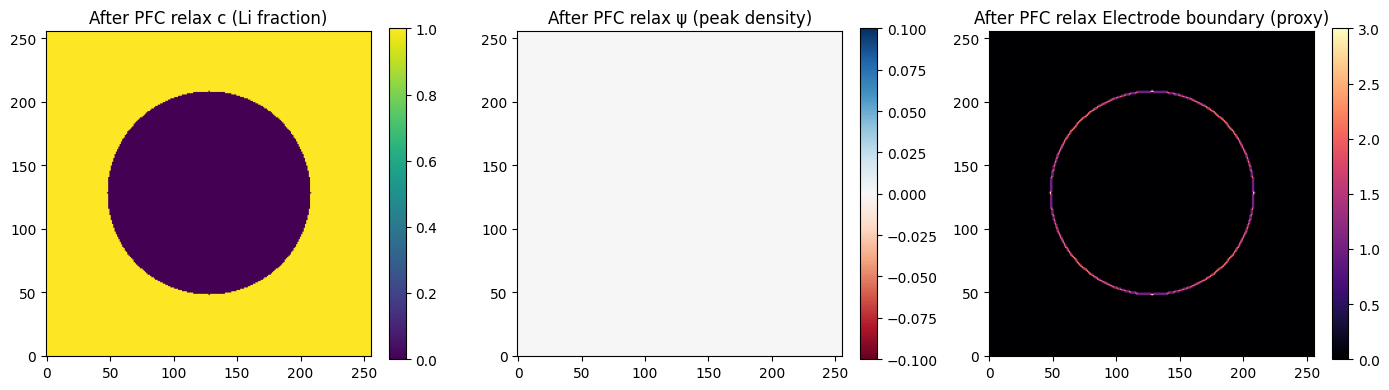

In [8]:
fig, axs = plot_fields(c, psi0, mask, title_prefix='After PFC relax')
plt.show()


Params: 256 256 r_electrode= 80
Mask pixels: inside= 20081 outside= 45455
Mask any? True Mask all? False


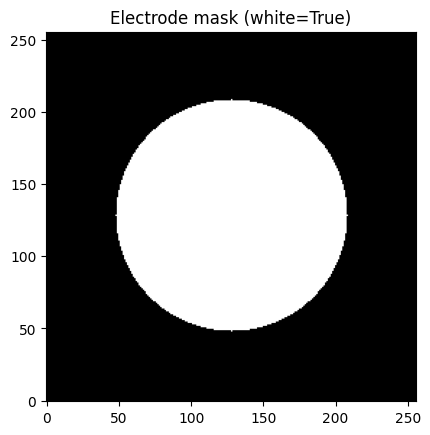

In [10]:

# --- Diagnostic cell ---
print('Params:', p.nx, p.ny, 'r_electrode=', p.r_electrode)

# Build mask with the SAME p that you pass to init_fields
X, Y, mask_dbg = make_grid(p)
print('Mask pixels: inside=', int(mask_dbg.sum()), 'outside=', int((~mask_dbg).sum()))
print('Mask any?', bool(mask_dbg.any()), 'Mask all?', bool(mask_dbg.all()))

# Visual check of the mask (white = electrode)
import matplotlib.pyplot as plt
plt.imshow(mask_dbg.T, origin='lower', cmap='gray')
plt.title('Electrode mask (white=True)')
plt.show()


c stats: min= 0.0 max= 1.0
mean c inside electrode: 0.0
mean c outside electrode: 1.0


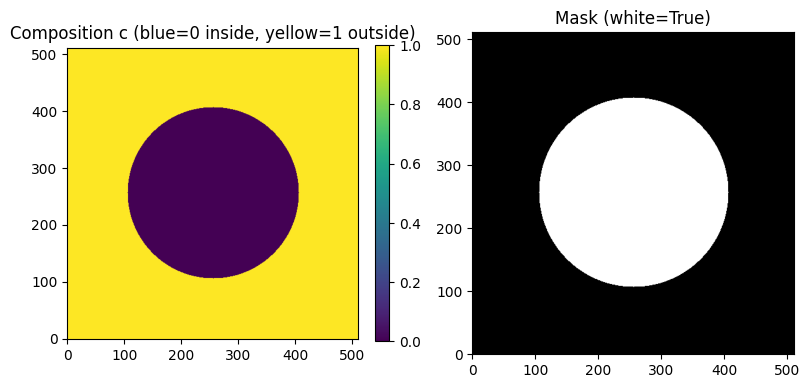

In [11]:
# --- Safe reinit cell ---
# 0) Fresh params (ensure r_electrode is reasonable)
p = Params(nx=512, ny=512, r_electrode=150, r_inside=-0.2, r_outside=0.2)

# 1) Build fields once
c, psi, r, mask = init_fields(p, seed=42)

# 2) FORCE the intended composition patten (FePO4 inside, Li reservoir)
c = np.where(mask, 0.0, 1.0)   # FePO4 (0) in electrode; Li reservoir (1) outside

# 3) (optional) quick sanity prints
import numpy as np
print('c stats: min=', float(c.min()), 'max=', float(c.max()))
print('mean c inside electrode:', float(c[mask].mean()))
print('mean c outside electrode:', float(c[~mask].mean()))

# 4) Visualize c and mask
fig, axs = plt.subplots(1,2, figsize=(8,4))
im0 = axs[0].imshow(c.T, origin='lower', cmap='viridis', vmin=0, vmax=1)
axs[0].set_title('Composition c (blue=0 inside, yellow=1 outside)')
plt.colorbar(im0, ax=axs[0], fraction=0.046)
axs[1].imshow(mask.T, origin='lower', cmap='gray')
axs[1].set_title('Mask (white=True)')
plt.tight_layout(); plt.show()


In [12]:
# Manual construction (equivalent to init_fields, but explicit)
X, Y, mask = make_grid(p)
c  = np.where(mask, 0.0, 1.0)  # FePO4 inside, Li reservoir outside
r  = np.full((p.nx, p.ny), p.r_outside, float); r[mask] = p.r_inside
psi = init_single_crystal_template(p, mask, amp=0.35, theta=0.0)


In [13]:
# simple banded smoothing of r near the mask boundary
from scipy.ndimage import distance_transform_edt
dist_in  = distance_transform_edt(mask)
dist_out = distance_transform_edt(~mask)
band = 3.0  # grid cells
w = np.clip((band - dist_out) / band, 0, 1)  # blend factor outside→inside over ~band cells
r = (1-w)*p.r_outside + w*p.r_inside
r[mask] = p.r_inside


In [14]:

# crystalline in electrode (r_inside > 0), amorphous in reservoir (r_outside < 0)
r = np.full_like(c, p.r_outside, dtype=np.float64)
r[mask] = p.r_inside


[PFC] step=  200 E= 1.252776e+02 dt= 2.898e-03 |psi|max=0.762
[PFC] step=  400 E= 2.383064e+01 dt= 2.999e-03 |psi|max=0.707
[PFC] step=  600 E=-2.678668e+01 dt= 3.447e-03 |psi|max=0.668
[PFC] step=  800 E=-5.744987e+01 dt= 3.300e-03 |psi|max=0.639
[PFC] step= 1000 E=-7.779455e+01 dt= 3.299e-03 |psi|max=0.616


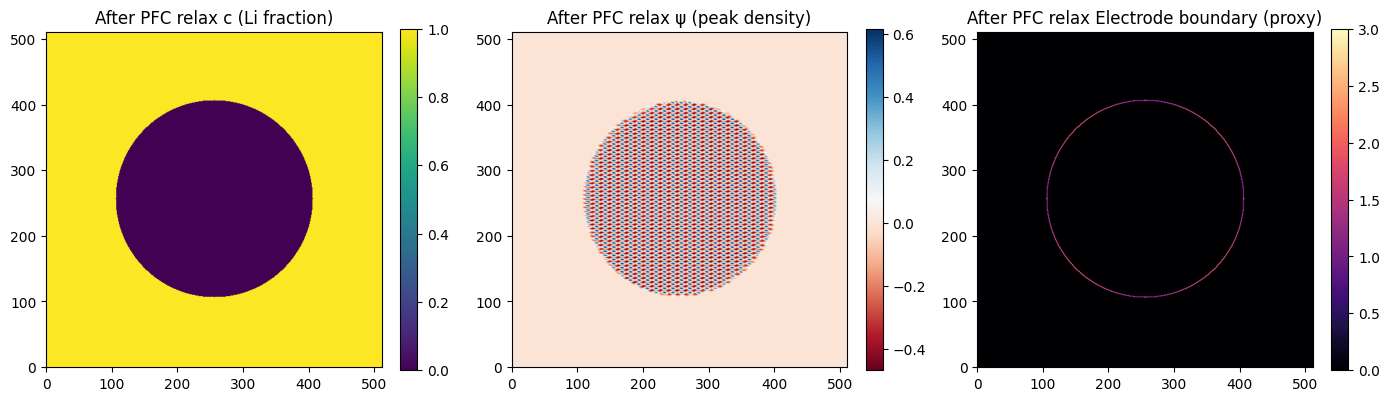

In [15]:
# 2) Relax ψ only (no CH step yet)
psi = pfc_relax_stable(psi, c, r, p,mask=mask,n_steps=1000, dt_max=0.005)

# 3) Visualize: ψ should show a crisp periodic field inside the mask
fig, axs = plot_fields(c, psi, mask, title_prefix='After PFC relax')
plt.show()


[PFC] step=  200  E= 2.749407e+02  dt= 2.000e-03  |ψ|_max=0.683
[PFC] step=  400  E= 1.649198e+02  dt= 2.000e-03  |ψ|_max=0.566
[PFC] step=  600  E= 1.085681e+02  dt= 2.000e-03  |ψ|_max=0.480


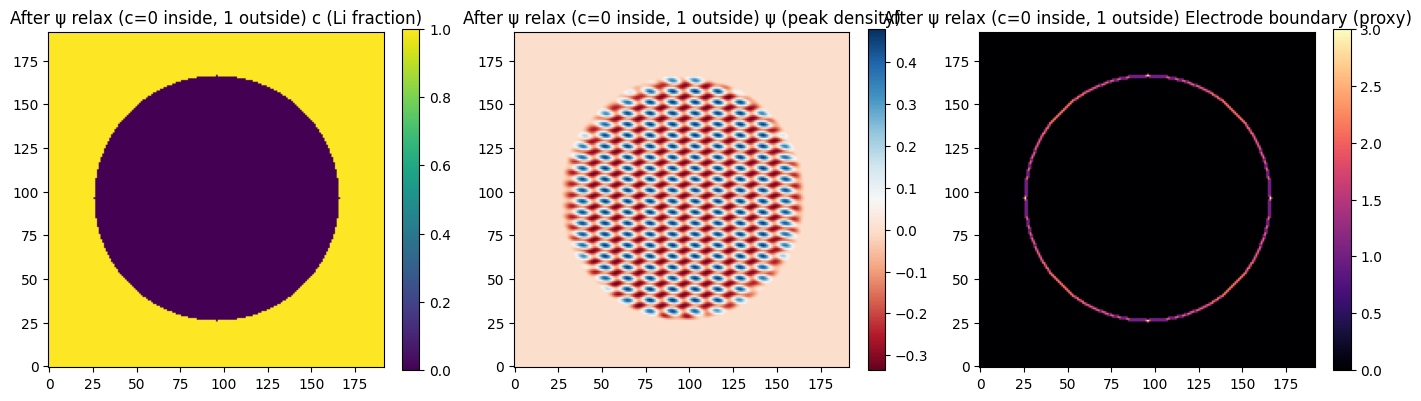

In [19]:
# Fresh params
p = Params(nx=192, ny=192, r_electrode=70, r_inside=0.20, r_outside=-0.2)

# Build fields
c, psi, r, mask = init_fields(p, seed=42)

# simple banded smoothing of r near the mask boundary
from scipy.ndimage import distance_transform_edt
dist_in  = distance_transform_edt(mask)
dist_out = distance_transform_edt(~mask)
band = 3.0  # grid cells
w = np.clip((band - dist_out) / band, 0, 1)  # blend factor outside→inside over ~band cells
r = (1-w)*p.r_outside + w*p.r_inside
r[mask] = p.r_inside

# crystalline in electrode (r_inside > 0), amorphous in reservoir (r_outside < 0)
r = np.full_like(c, p.r_outside, dtype=np.float64)
r[mask] = p.r_inside

# Force the intended initial concentration pattern
c = np.where(mask, 0.0, 1.0)   # FePO4 inside, Li reservoir outside

# Seed ψ with an analytic crystal only inside the electrode
psi = init_single_crystal_template(p, mask, amp=0.35, theta=0.0)
#psi = init_polycrystal_voronoi(p, mask, n_grains=10, amp=0.32, seed=123)

# Stable PFC relax of ψ at fixed c, r
psi = pfc_relax_stable(
    psi, c, r, p,
    mask=mask,
    n_steps=600,
    dt0=0.001,      # small initial step for stability
    dt_max=0.002,
    psi_clip=2.0,
    enforce_amorphous=True,
    verbose_every=200
)

# Visual check
fig, axs = plot_fields(c, psi, mask, title_prefix='After ψ relax (c=0 inside, 1 outside)')
plt.show()


In [17]:
import numpy as np, matplotlib.pyplot as plt, sys, os
sys.path.append('src')
from chpfc import Params, init_fields, ch_step, extract_peak_coords
from plotting import plot_fields

p = Params(nx=192, ny=192, r_electrode=70)
#c, psi, r, mask = init_fields(p, seed=0)
psi = pfc_relax_stable(psi, c, r, p, mask=mask, n_steps=500, dt_max=0.002)

snapshots = []
T_total = 100
for t in range(T_total):
    # enforce reservoir boundary c=1 outside electrode
    c[~mask] = 1.0
    c = ch_step(c, psi, p, dt=5e-3, n_sub=10)
    # fast PFC relaxation step every few diffusion steps
    if t % 10 == 0:
        psi = pfc_relax_stable(psi, c, r, p, mask=mask, n_steps=500, dt_max=0.002)
    if t in [int(T_total/4),int(T_total/2) , int(T_total*3/4), T_total-1]:
        snapshots.append((t, c.copy(), psi.copy()))

len(snapshots)


[PFC] step=  200 E=-8.919922e+01 dt= 2.000e-03 |psi|max=0.601
[PFC] step=  400 E=-9.839202e+01 dt= 2.000e-03 |psi|max=0.589
[PFC] step=  200 E=-1.085070e+02 dt= 2.000e-03 |psi|max=0.575
[PFC] step=  400 E=-1.146356e+02 dt= 2.000e-03 |psi|max=0.567
[PFC] step=  200 E=-1.148359e+02 dt= 2.000e-03 |psi|max=0.557
[PFC] step=  400 E=-1.212844e+02 dt= 2.000e-03 |psi|max=0.552
[PFC] step=  200 E=-1.299535e+02 dt= 2.000e-03 |psi|max=0.546
[PFC] step=  400 E=-1.355099e+02 dt= 2.000e-03 |psi|max=0.542
[PFC] step=  200 E=-1.433641e+02 dt= 2.000e-03 |psi|max=0.537
[PFC] step=  400 E=-1.485704e+02 dt= 2.000e-03 |psi|max=0.534
[PFC] step=  200 E=-1.561650e+02 dt= 2.000e-03 |psi|max=0.530
[PFC] step=  400 E=-1.612643e+02 dt= 2.000e-03 |psi|max=0.529
[PFC] step=  200 E=-1.687913e+02 dt= 2.000e-03 |psi|max=0.527
[PFC] step=  400 E=-1.738678e+02 dt= 2.000e-03 |psi|max=0.526
[PFC] step=  200 E=-1.813882e+02 dt= 2.000e-03 |psi|max=0.524
[PFC] step=  400 E=-1.864271e+02 dt= 2.000e-03 |psi|max=0.524
[PFC] st

4

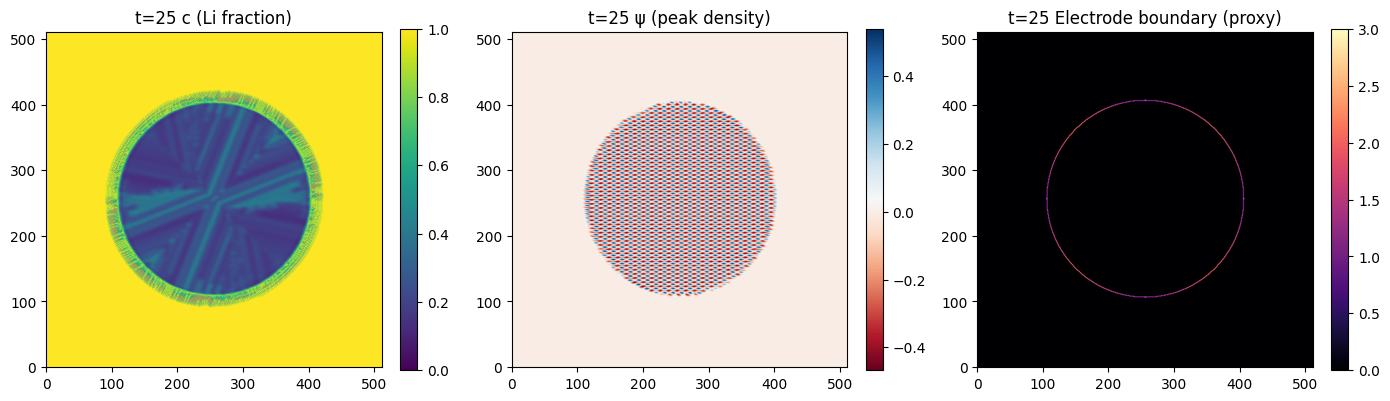

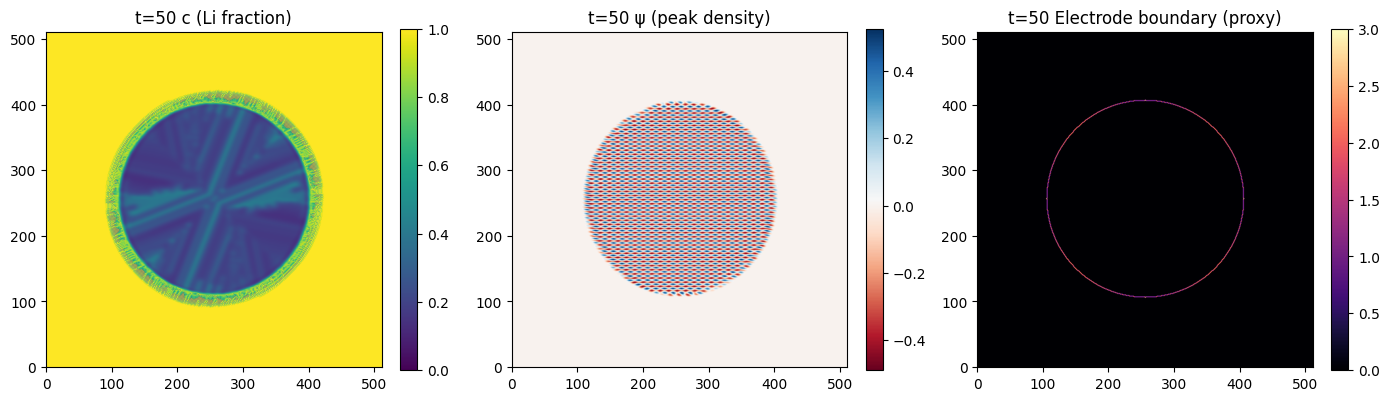

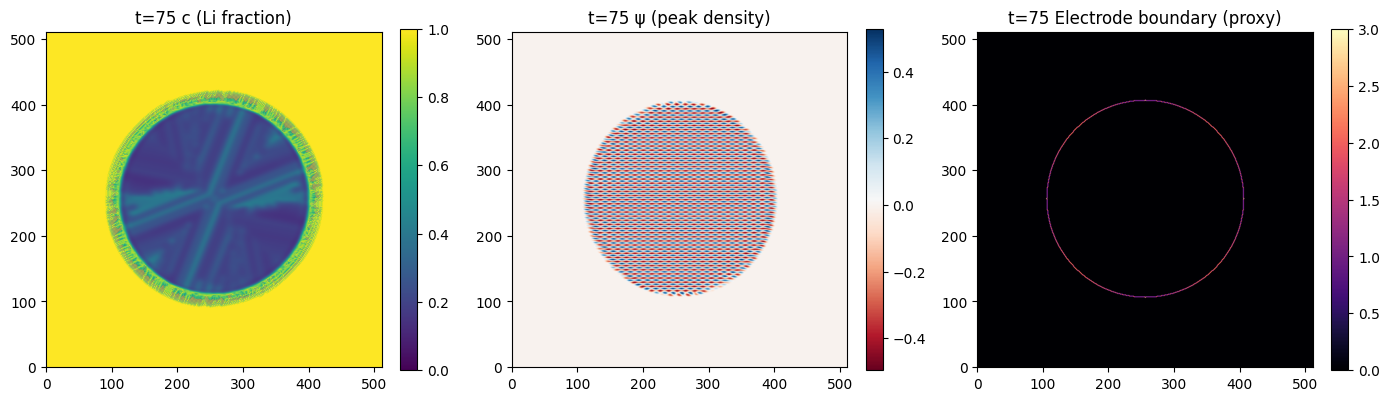

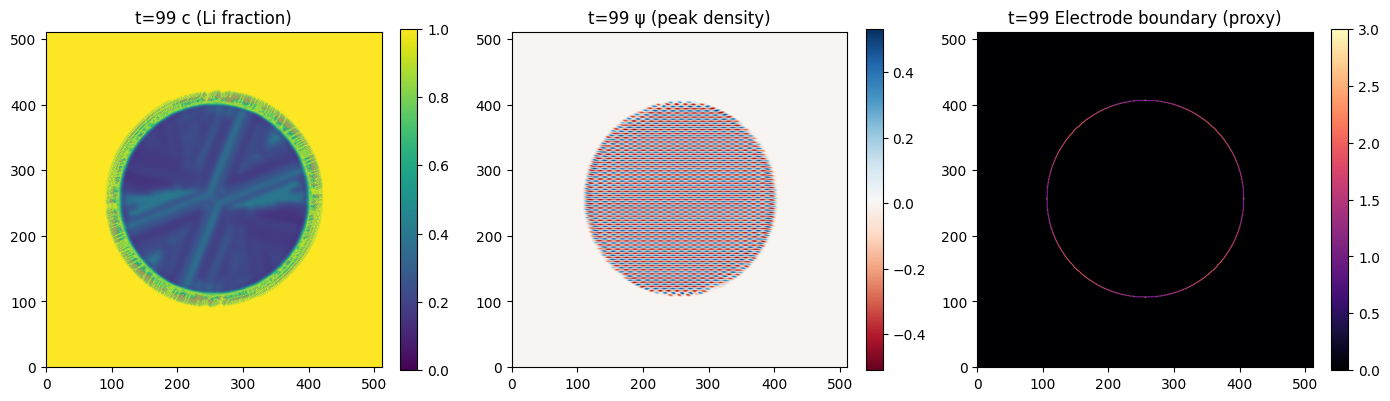

In [18]:
for t, cc, pp in snapshots:
    fig, axs = plot_fields(cc, pp, mask, title_prefix=f't={t}')
    plt.show()

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, maximum_filter
from scipy.spatial import cKDTree

# 1) Peak detection from ψ
def extract_peak_coords_from_psi(psi, threshold=0.02, min_distance=2, mask=None):
    sm = gaussian_filter(psi, sigma=0.6)
    if mask is not None:
        sm = sm * mask.astype(float)
    locmax = sm == maximum_filter(sm, size=(2*min_distance+1))
    vals = sm[locmax]
    coords = np.array(np.nonzero(locmax)).T  # (N, 2) in (i,j)
    keep = vals > threshold
    return coords[keep]  # (i, j) integer indices

# 2) Peak-marker image
def peak_marker_image(shape, coords, sigma=1.2, normalize=True):
    img = np.zeros(shape, dtype=float)
    for (i, j) in coords:
        if 0 <= i < shape[0] and 0 <= j < shape[1]:
            img[i, j] = 1.0
    img = gaussian_filter(img, sigma=sigma)
    if normalize and img.max() > 0:
        img /= img.max()
    return img

# 3) Local orientation at each peak (principal direction of neighbor vectors)
def local_orientation_angles(coords, k=6):
    if len(coords) == 0:
        return np.array([])
    pts = np.array([[float(i), float(j)] for i,j in coords])   # (i,j)
    kd = cKDTree(pts)
    d, idx = kd.query(pts, k=min(k, len(pts)))  # neighbor indices
    angs = []
    for m in range(len(pts)):
        nbrs = pts[idx[m,1:]] - pts[m]
        if len(nbrs) == 0:
            angs.append(0.0); continue
        v = nbrs - nbrs.mean(0)
        cov = v.T @ v
        w, V = np.linalg.eigh(cov)              # PCA
        principal = V[:, -1]
        angs.append(np.arctan2(principal[1], principal[0]))
    return np.unwrap(np.array(angs))

# 4) Cluster peaks into grains by orientation (DBSCAN if available; fallback to binning)
def cluster_orientations(angles, eps=0.20, min_samples=5, n_bins=12):
    try:
        from sklearn.cluster import DBSCAN
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit(angles.reshape(-1,1)).labels_
    except Exception:
        bins = np.linspace(angles.min()-1e-6, angles.max()+1e-6, n_bins+1)
        labels = np.digitize(angles, bins) - 1
    return labels

# 5) Rasterize grain labels over pixels inside the electrode (nearest-peak Tessellation)
def rasterize_grain_labels(coords, labels, shape, mask=None):
    lbl_img = np.full(shape, -1, dtype=int)
    if len(coords) == 0:
        return lbl_img
    pts = np.array([[float(i), float(j)] for i,j in coords])
    kd = cKDTree(pts)
    if mask is None:
        ii, jj = np.indices(shape)
        q = np.c_[ii.ravel(), jj.ravel()]
        _, idx = kd.query(q)
        lbl_img = labels[idx].reshape(shape)
    else:
        ii, jj = np.nonzero(mask)
        q = np.c_[ii, jj]
        _, idx = kd.query(q)
        lbl_img[mask] = labels[idx]
    return lbl_img

# 6) Boundary mask between grain labels
def grain_boundaries_from_labels(lbl_img, mask=None):
    if mask is None:
        mask = np.ones_like(lbl_img, bool)
    L = lbl_img
    # 4-neighborhood differences
    diff = (
        (np.roll(L,1,0) != L) |
        (np.roll(L,-1,0) != L) |
        (np.roll(L,1,1) != L) |
        (np.roll(L,-1,1) != L)
    )
    edges = diff & mask & (L >= 0)
    return edges

# 7) One-shot plotter
def plot_peak_markers_and_gbs(psi, mask, c=None,
                              peak_thresh=0.02, min_dist=2,
                              angle_eps=0.20, angle_min_samples=5,
                              marker_sigma=1.2, gb_color='crimson'):
    # Peaks
    coords = extract_peak_coords_from_psi(psi, threshold=peak_thresh, min_distance=min_dist, mask=mask)
    marker = peak_marker_image(psi.shape, coords, sigma=marker_sigma, normalize=True)
    # Orientation -> grain labels
    angs = local_orientation_angles(coords, k=6)
    labels = cluster_orientations(angs, eps=angle_eps, min_samples=angle_min_samples)
    # Rasterize & boundaries
    lbl_img = rasterize_grain_labels(coords, labels, psi.shape, mask=mask)
    gb = grain_boundaries_from_labels(lbl_img, mask=mask)

    # Plot
    fig, axs = plt.subplots(1, 3 if c is not None else 2, figsize=(14,4))
    ax0 = axs[0]
    im0 = ax0.imshow(marker.T, origin='lower', cmap='gray', vmin=0, vmax=1)
    ax0.set_title('Peak‑marker image')
    ax0.contour(gb.T, levels=[0.5], colors=[gb_color], linewidths=1.2)  # GB overlay

    ax1 = axs[1]
    # pseudo-colored grains (only inside mask)
    grain_vis = np.ma.masked_array(lbl_img, mask=(~mask) | (lbl_img<0))
    im1 = ax1.imshow(grain_vis.T, origin='lower', cmap='tab20')
    ax1.set_title('Grain labels (NN tessellation)')
    ax1.contour(gb.T, levels=[0.5], colors=[gb_color], linewidths=1.2)

    if c is not None:
        ax2 = axs[2]
        im2 = ax2.imshow(c.T, origin='lower', cmap='viridis', vmin=0, vmax=1)
        ax2.set_title('Composition c')
        plt.colorbar(im2, ax=ax2, fraction=0.046)

    for ax in axs: ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

    # Return results for further analysis
    return {
        'coords': coords, 'angles': angs, 'labels': labels,
        'label_image': lbl_img, 'gb_mask': gb, 'peak_marker': marker
    }


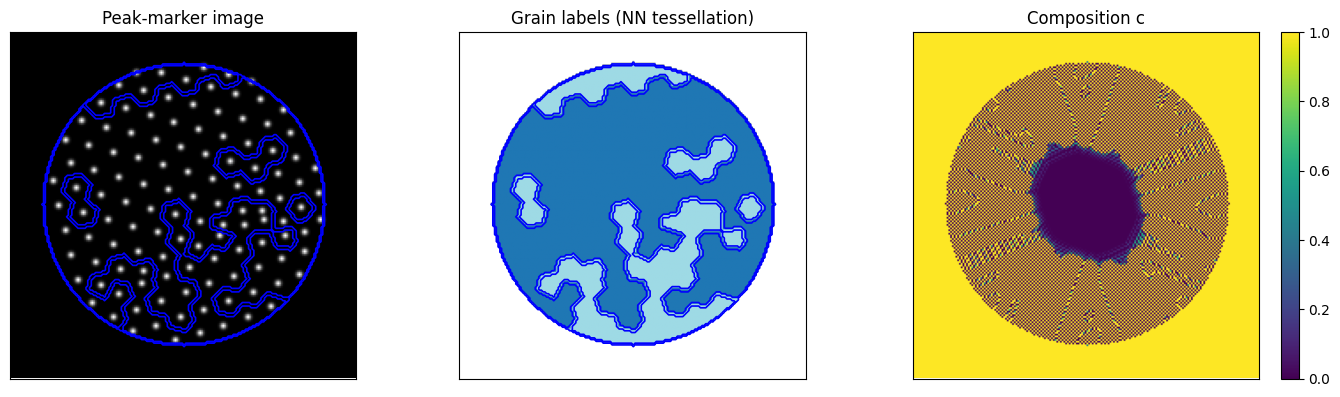

In [122]:
# Adjust these parameters to experiment with clustering
clustering_angle_eps = 0.25
clustering_min_samples = 5

out = plot_peak_markers_and_gbs(psi, mask, c=c,
                                peak_thresh=0.01, min_dist=1,
                                angle_eps=clustering_angle_eps, angle_min_samples=clustering_min_samples,
                                marker_sigma=1.2, gb_color='blue')

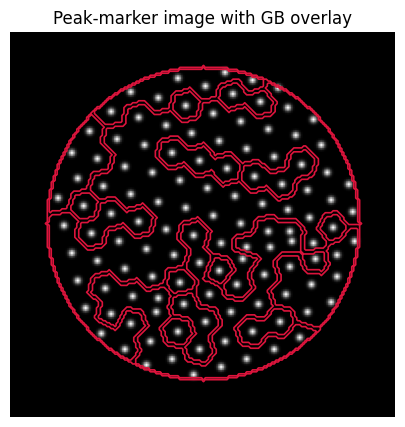

In [126]:
# 1) peaks
coords = extract_peak_coords_from_psi(psi, threshold=0.02, min_distance=2, mask=mask)

# 2) peak-marker
marker = peak_marker_image(psi.shape, coords, sigma=1.2)

# 3) orientation per peak
angs = local_orientation_angles(coords, k=6)

# 4) cluster peaks into grains
labels = cluster_orientations(angs, eps=0.20, min_samples=5)   # or fallback to bins

# 5) rasterize grain labels over pixels inside the electrode
lbl_img = rasterize_grain_labels(coords, labels, psi.shape, mask=mask)

# 6) grain boundary mask
gb = grain_boundaries_from_labels(lbl_img, mask=mask)

# 7) overlay on peak marker
plt.figure(figsize=(6,5))
plt.imshow(marker.T, origin='lower', cmap='gray', vmin=0, vmax=1)
plt.contour(gb.T, levels=[0.5], colors=['crimson'], linewidths=1.2)
plt.title('Peak‑marker image with GB overlay')
plt.axis('off'); plt.show()


In [36]:
from chpfc import scale_amplitude_to_equilibrium,choose_pitches_from_params, init_polycrystal_tessellation_auto, pfc_relax_stable, estimate_equilibrium_amplitude, apply_G2

coarse_factor = 2.0

p.r_inside = -0.6  # before init_fields(p)

# Build c and r (crystalline in electrode, amorphous in reservoir)
c = np.where(mask, 0.0, 1.0)  # or your preferred initial composition
r = np.full_like(c, p.r_outside, dtype=float)
r[mask] = p.r_inside

print("mask.any():", bool(mask.any()), "mask.sum:", int(mask.sum()))
print("r stats: inside mean=", float(r[mask].mean()), "outside mean=", float(r[~mask].mean()))

# Build a very small test seed to check energy signs
H, W = mask.shape
psi_test = np.zeros_like(r, dtype=float)
ii, jj = np.nonzero(mask)
if len(ii) == 0:
    raise RuntimeError("Mask has no True pixels; check make_grid / r_electrode size.")

# put a few cosine cycles at near k=1 inside the mask
i0, j0 = ii[len(ii)//2], jj[len(ii)//2]
# Calculate cosine values only for the masked locations
cosine_values = np.cos(2*np.pi*( (ii-i0)/pitch )) + np.cos(2*np.pi*((jj-j0)/pitch))
psi_test[mask] = cosine_values


Gpsi = apply_G2(psi_test, np.where(mask, 0.0, 1.0), p)  # c is OK to be simple here
# Use the correct r field here
A = 0.5 * p.gamma * np.sum(r[mask] * psi_test[mask]**2 + psi_test[mask] * Gpsi[mask])
B = 0.25 * p.gamma * np.sum(psi_test[mask]**4)
print(f"A={A:.3e}, B={B:.3e},  expect s>0?  {A<0}")




# Inside your script (after building p, c, r, mask)
psi0, labels, seeds, thetas, (pitch_x, pitch_y), scale_s = init_polycrystal_tessellation_auto(
    p, mask,
    n_grains=20,
    seed=123,
    coarse_factor=2.0,     # <-- 2x2 -> 4 lattices averaged
    k0=1.0,
    r_field=r,             # from init_fields
    c=c,                   # composition field
    amp_clip=1.8,
    smooth_boundary=True,
    blur_sigma=0.4
)
print("pitches:", pitch_x, pitch_y, "global amplitude scale:", scale_s)


print(f"Chosen pitches: pitch_x={px:.2f} px, pitch_y={py:.2f} px; amplitude scale s*={s:.3f}")

# Optional: short PFC relax to tidy boundaries
#psi = pfc_relax_stable(psi0, c, r, p, mask=mask, n_steps=800, dt0=1e-3, dt_max=2e-3, psi_clip=1.8)

mask.any(): True mask.sum: 20081
r stats: inside mean= -0.6 outside mean= 0.20000000000000004
A=9.901e+04, B=1.128e+04,  expect s>0?  False
pitches: 6.126441553971258 12.566370614359172 global amplitude scale: 0.0
Chosen pitches: pitch_x=6.13 px, pitch_y=12.57 px; amplitude scale s*=0.000


In [28]:
# 0) Params and base fields
p = Params()
c, psi_noise, r, mask = init_fields(p)  # c: 0 inside, 1 outside; r: -0.2 inside, +0.2 outside

# 1) If you want 4-lattice averaging per peak (2x2):
coarse = 2.0

# 2) Build analytic polycrystal and auto-scale amplitude:
psi0, labels, seeds, thetas, (px, py), s = init_polycrystal_tessellation_auto(
    p, mask,
    n_grains=20, seed=123,
    coarse_factor=coarse, k0=1.0,
    r_field=r, c=c,
    amp_clip=1.8, smooth_boundary=True, blur_sigma=0.4
)
print(f"pitches px={px:.3f}, py={py:.3f}, amplitude scale s={s:.3f}")

# 3) Optional: run a short PFC relaxation to “settle” ψ:
psi_eq = pfc_relax_stable(psi0, c, r, p, mask=mask, n_steps=500, dt0=1e-3)


pitches px=6.126, py=12.566, amplitude scale s=0.000
[PFC] step=  200  E= 0.000000e+00  dt= 2.000e-03  |ψ|_max=0.000
[PFC] step=  400  E= 0.000000e+00  dt= 2.000e-03  |ψ|_max=0.000


In [40]:
# --- Params ---
p = Params()
p.r_inside = -0.60        # <- make both kx≈1.03 and ky=0.5 unstable
# p.r_outside stays positive (+0.2) so the reservoir remains amorphous

# --- Initialize fields ---
c, psi_noise, r, mask = init_fields(p)

# --- 4-lattice (2×2) seed with automatic amplitude scaling ---
psi0, labels, seeds, thetas, (px, py), s = init_polycrystal_tessellation_auto(
    p, mask,
    n_grains=20, seed=123,
    coarse_factor=2.0, k0=1.0,
    r_field=r, c=c,
    amp_clip=1.8, smooth_boundary=True, blur_sigma=0.4
)
print(f"pitches: px={px:.3f}, py={py:.3f}, amplitude scale s={s:.3f}")



pitches: px=6.126, py=12.566, amplitude scale s=0.000


In [30]:
p.r_inside

-0.6

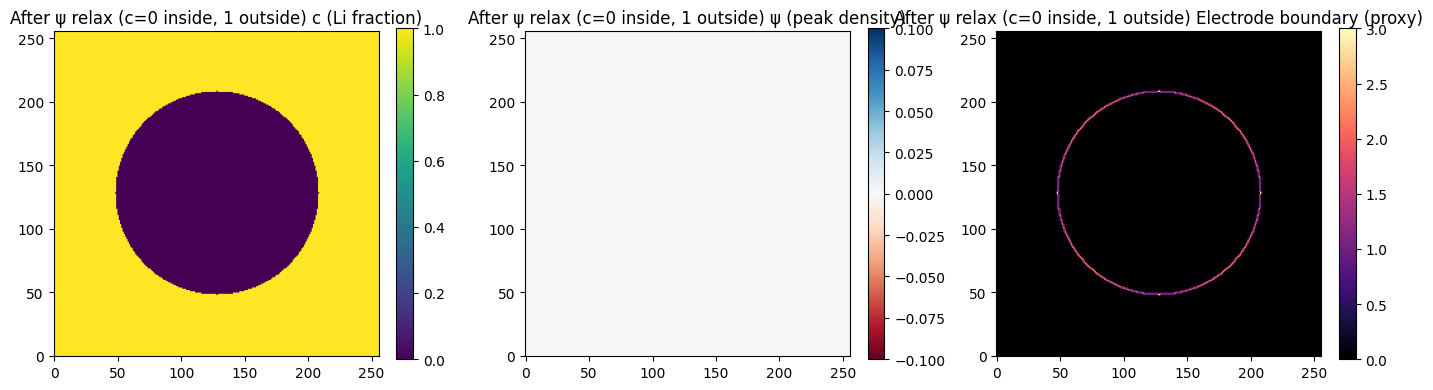

In [37]:
# Visual check
fig, axs = plot_fields(c, psi0, mask, title_prefix='After ψ relax (c=0 inside, 1 outside)')
plt.show()

In [39]:
from chpfc import init_poly_voronoi_simple
p = Params(nx=256, ny=256, r_electrode=80)

# base fields
c, psi, r_field, mask = init_fields(p, seed=0)

# simplest: hex lattice, many triple points, gentle 1-px taper
psi0, labels, seeds, thetas = init_poly_voronoi_simple(
    p, mask,
    n_grains=24, amp=0.30, k=1.0,
    lattice='hex', band_px=1, seed=123
)

def anisotropic_laplacian_c_frozen(u):
    return anisotropic_laplacian_c(
        u, c0, p.alpha_fp, p.beta_fp, p.alpha_lfp, p.beta_lfp, p.dx, p.xi
    )

# Inside a short warm-up:
for _ in range(5):  # 3–10 outer steps usually enough
    # use a local G2 that calls anisotropic_laplacian_c_frozen instead of the c-dependent one
    psi = pfc_relax_stable(
        psi, c0, r_field, p, mask=mask, n_steps=300, enforce_amorphous=True, verbose_every=0
    )

    psi[~mask] = 0.0
# optional: short relax to clean up seams
psi = pfc_relax_stable(psi0, c, r_field, p, mask=mask, n_steps=1000, enforce_amorphous=True,verbose_every=100)


[PFC] step=  100 E= 3.323278e+01 dt= 2.000e-03 |psi|max=0.201
[PFC] step=  200 E= 1.078113e+01 dt= 2.000e-03 |psi|max=0.195
[PFC] step=  300 E= 4.590103e+00 dt= 2.000e-03 |psi|max=0.189
[PFC] step=  400 E= 1.735683e+00 dt= 2.000e-03 |psi|max=0.183
[PFC] step=  500 E= 5.639001e-02 dt= 2.000e-03 |psi|max=0.179
[PFC] step=  600 E=-1.090246e+00 dt= 2.000e-03 |psi|max=0.180
[PFC] step=  700 E=-1.957317e+00 dt= 2.000e-03 |psi|max=0.185
[PFC] step=  800 E=-2.664281e+00 dt= 2.000e-03 |psi|max=0.189
[PFC] step=  900 E=-3.275045e+00 dt= 2.000e-03 |psi|max=0.194
[PFC] step= 1000 E=-3.827050e+00 dt= 2.000e-03 |psi|max=0.199


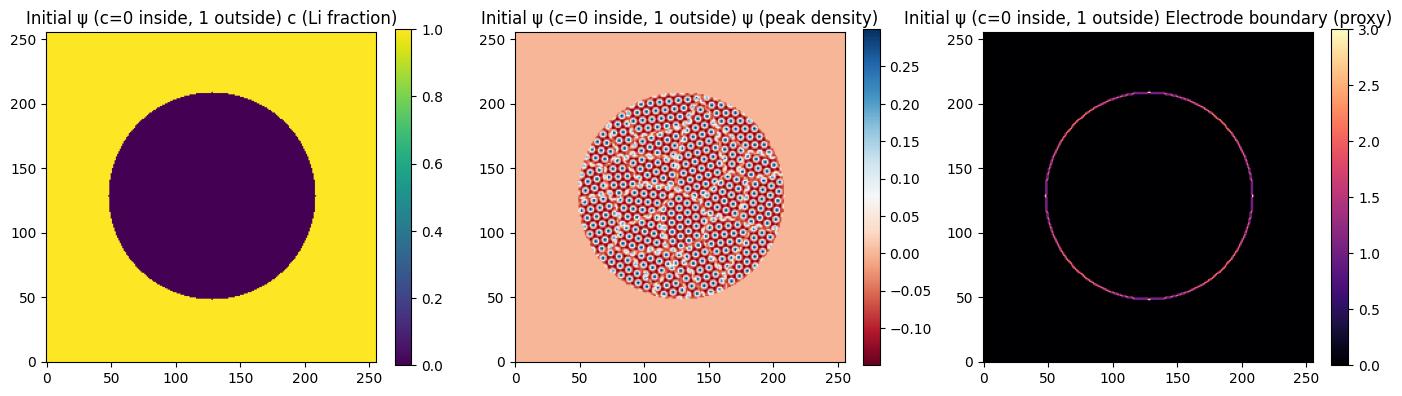

In [41]:
fig, axs = plot_fields(c, psi0, mask, title_prefix='Initial ψ (c=0 inside, 1 outside)')
plt.show()

In [42]:
# After init
c, psi, r_field, mask = init_fields(p, seed=0)
print("r_inside mean =", float(r_field[mask].mean()))     # should be < 0 (e.g., -0.2 to -0.4)
print("r_outside mean =", float(r_field[~mask].mean()))   # should be > 0
assert mask.dtype == bool and mask.shape == psi.shape and mask.sum() > 0


r_inside mean = -0.20000000000000004
r_outside mean = 0.20000000000000004


In [45]:
# Temporarily override anisotropy: alpha=beta=1, xi=1
from chpfc import d2x, d2y

def anisotropic_laplacian_c_iso(u):
    return d2x(u, p.dx) + d2y(u, p.dx)  # standard Laplacian
def apply_G2_iso(u):
    Lu  = anisotropic_laplacian_c_iso(u)
    L2u = anisotropic_laplacian_c_iso(Lu)
    return u + 2*Lu + L2u

# Quick relax with the isotropic operator by monkey-patching inside a tiny wrapper:
def pfc_relax_iso(psi, c, r_field, n_steps=800, dt0=8e-4):
    psi = psi.copy().astype(np.float64)
    E = lambda s: float(p.gamma*np.sum(0.5*(r_field*s**2 + s*apply_G2_iso(s)) + 0.25*s**4))
    dt, Et = dt0, E(psi)
    for _ in range(n_steps):
        g = p.gamma * (r_field*psi + apply_G2_iso(psi) + psi**3)
        trial = np.clip(psi - dt*g, -1.8, 1.8)
        trial[~mask] = 0.0
        Et_new = E(trial)
        if Et_new <= Et - 1e-8*dt*np.sum(g*g):
            psi, Et = trial, Et_new; dt = min(dt*1.1, 2e-3)
        else:
            dt = max(dt*0.5, 1e-5)
    return psi

# Seed with hex (3-mode) to avoid grid-locking
psi0_hex, labels, seeds, thetas = init_poly_voronoi_simple(
    p, mask, n_grains=16, amp=0.30, k=1.0, lattice='hex', band_px=1, seed=123
)
psi_iso = pfc_relax_iso(psi0_hex, c, r_field, n_steps=800)

print("isotropic |psi|_max =", float(np.abs(psi_iso[mask]).max()))


isotropic |psi|_max = 0.37270353519102506


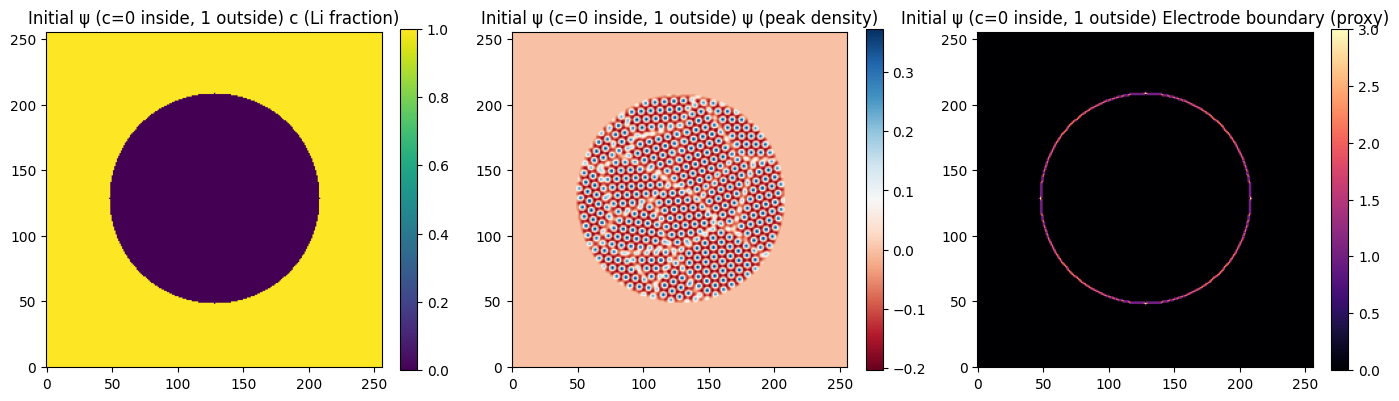

In [46]:
fig, axs = plot_fields(c, psi_iso, mask, title_prefix='Initial ψ (c=0 inside, 1 outside)')
plt.show()

In [55]:
p.r_inside = -0.35          # deeper well
p.xi = 0.8                  # milder anisotropy for warm-up
n_grains = 20
psi0, labels, seeds, thetas = init_poly_voronoi_simple(
    p, mask, n_grains=n_grains, amp=0.30, k=1.0, lattice='hex', band_px=1, seed=4
)
psi = pfc_relax_stable(
    psi0, c, r_field, p, mask=mask,
    n_steps=800, dt0=8e-4, dt_max=2e-3,
    psi_clip=1.8, enforce_amorphous=True, verbose_every=200
)
# Now restore full anisotropy and relax a bit more
p.xi = 1.0
psi = pfc_relax_stable(psi, c, r_field, p, mask=mask, n_steps=400, verbose_every=200)



[PFC] step=  200 E= 4.485138e+00 dt= 2.000e-03 |psi|max=0.228
[PFC] step=  400 E=-7.825612e+00 dt= 2.000e-03 |psi|max=0.234
[PFC] step=  600 E=-1.287300e+01 dt= 2.000e-03 |psi|max=0.257
[PFC] step=  800 E=-1.693679e+01 dt= 2.000e-03 |psi|max=0.279
[PFC] step=  200 E= 5.597834e+00 dt= 2.000e-03 |psi|max=0.260
[PFC] step=  400 E=-5.229383e+00 dt= 2.000e-03 |psi|max=0.247


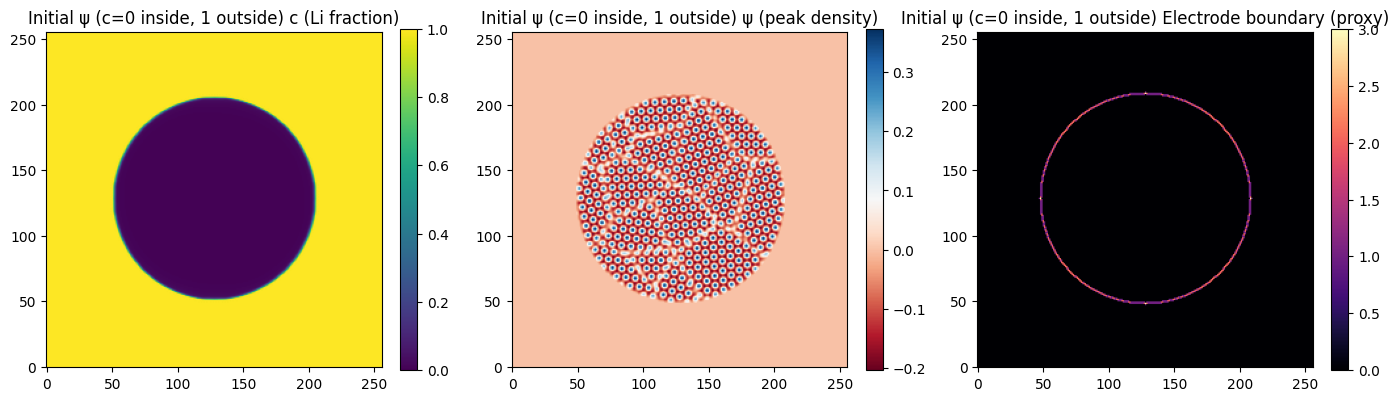

In [56]:
fig, axs = plot_fields(c, psi_iso, mask, title_prefix='Initial ψ (c=0 inside, 1 outside)')
plt.show()

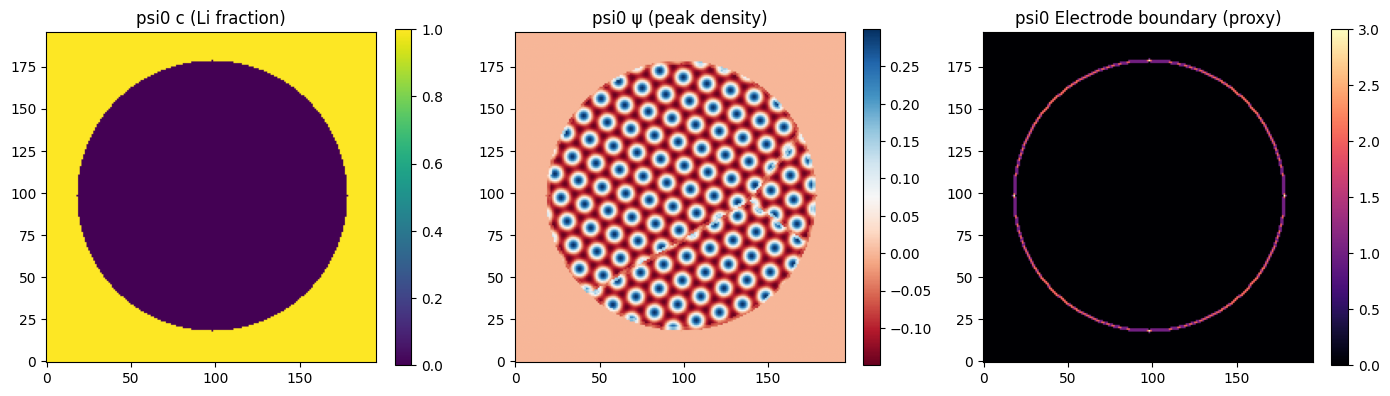

[PFC] step=  200 E= 1.933762e+01 dt= 1.000e-04 |psi|max=0.299
[PFC] step=  400 E= 1.693257e+01 dt= 1.000e-04 |psi|max=0.298


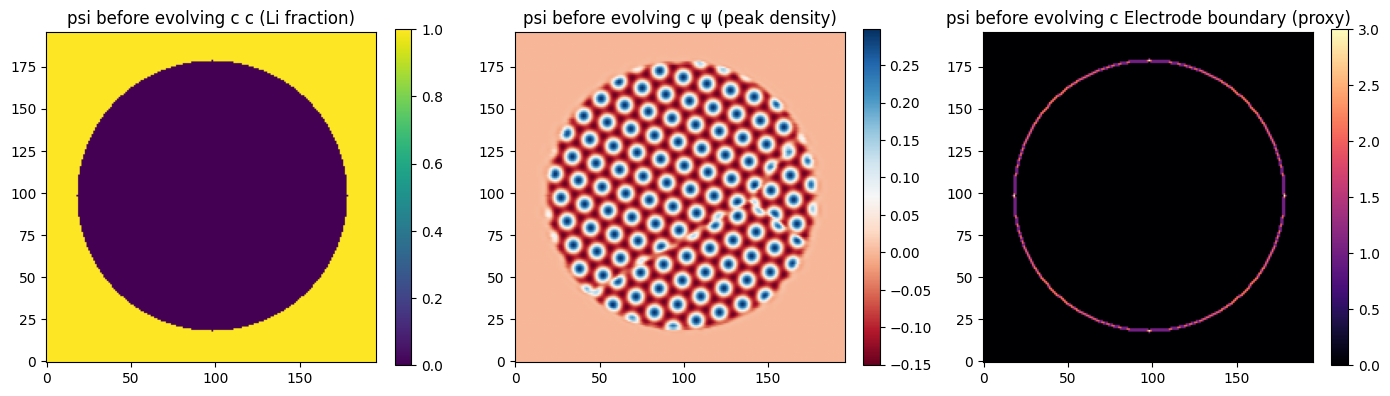

[0001] |psi|max=0.298  frac_zero=0.000%  c_mean=0.1086


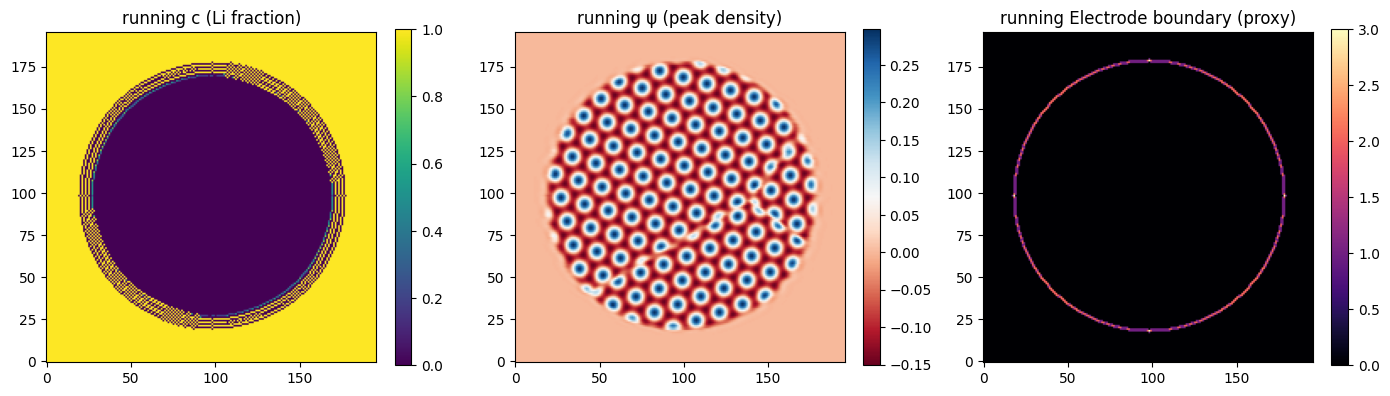

[0020] |psi|max=0.289  frac_zero=0.000%  c_mean=0.5080


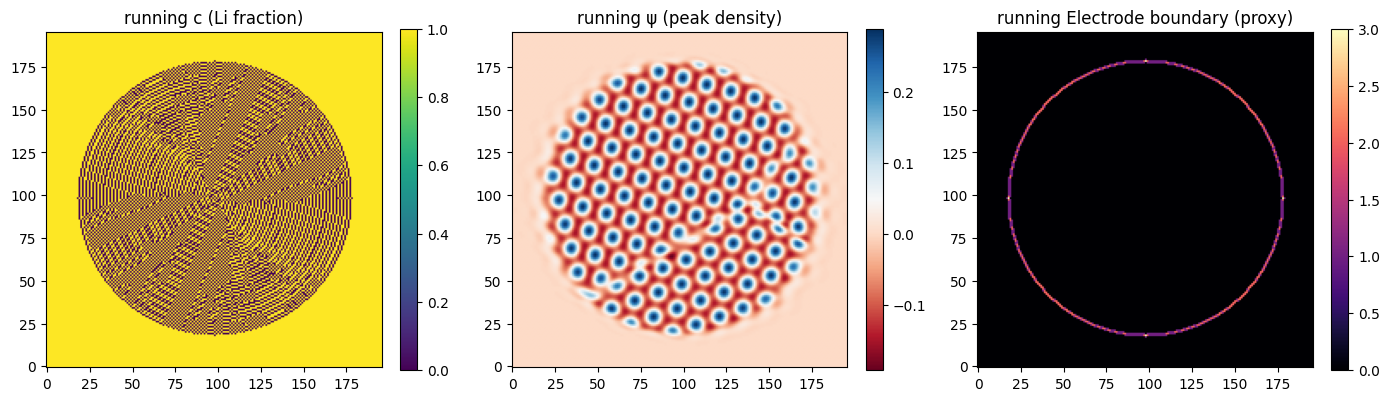

[0040] |psi|max=0.285  frac_zero=0.000%  c_mean=0.5080


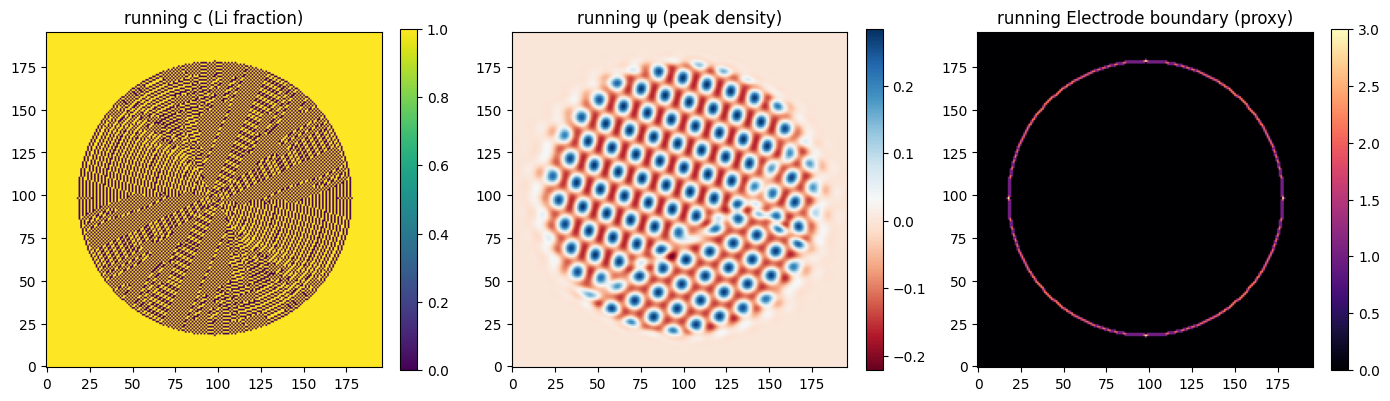

In [ ]:
# --- imports: assume CP-PFC_clean.py is on your PYTHONPATH
from chpfc import (
    Params, init_fields, init_poly_voronoi_simple, pfc_relax_stable, ch_step
)
import numpy as np
import os

# --- parameters
p = Params(nx=196, ny=196, r_electrode=80,
           r_inside=-0.20,   # keep negative inside electrode to favor crystalline ψ
           xi=1.0,           # anisotropy strength; see warm-up ramp below
           gamma=1.0, kappa=4.0, RT=1.0, Om=2.0)

# --- base fields (mask, r_field)
c, psi, r_field, mask = init_fields(p, seed=0)
p.xi = 0.8                  # milder anisotropy for warm-up
n_grains = 3
psi0, labels, seeds, thetas = init_poly_voronoi_simple(
    p, mask, n_grains=n_grains, amp=0.30, k=0.5, band_px=1, seed=4
)
fig, axs = plot_fields(c, psi0, mask, title_prefix='psi0')
plt.show()
psi = pfc_relax_stable(
    psi0, c, r_field, p, mask=mask,
    n_steps=500, dt0=1e-5, dt_max=1e-4,
    psi_clip=1.8, enforce_amorphous=False, verbose_every=200
)
# Now restore full anisotropy and relax a bit more
p.xi = 1.0
# --- seed ψ with a simple polycrystal; hex triads are robust against lamellae
#psi0, labels, seeds, thetas = init_poly_voronoi_simple(
#    p, mask, n_grains=24, amp=0.30, k=1.0,
#    lattice='hex', band_px=1, seed=123
#)

# --- let ψ settle at the initial composition
#psi = pfc_relax_stable(
#    psi0, c, r_field, p, mask=mask,
#    n_steps=600, dt0=8e-4, dt_max=2e-3,
#    psi_clip=1.8, enforce_amorphous=True, verbose_every=200
#)
fig, axs = plot_fields(c, psi, mask, title_prefix='psi before evolving c')
plt.show()
# --- time stepping parameters
n_outer   = 500          # number of outer (macro) steps
pfc_steps = 500          # ψ relax iterations per outer step
ch_dt     = 1e-3         # CH time step
ch_sub    = 5            # CH substeps per outer step
save_every = 20          # diagnostics cadence

outdir = "run_out"
os.makedirs(outdir, exist_ok=True)

def diagnostics(step, psi, c):
    psi_max = float(np.abs(psi[mask]).max())
    frac_zero = float(np.mean((np.abs(psi[mask]) < 1e-4)))
    c_mean = float(c[mask].mean())
    print(f"[{step:04d}] |psi|max={psi_max:.3f}  frac_zero={frac_zero:.3%}  c_mean={c_mean:.4f}")

# --- optional warm-up: gentler anisotropy for first few outer steps
xi_start, xi_final, warmup_steps = 0.85, 1.00, 15

for n in range(1, n_outer + 1):

    # ramp anisotropy slowly at the beginning (optional but helpful)
    if n <= warmup_steps:
        p.xi = xi_start + (xi_final - xi_start) * (n / warmup_steps)
    else:
        p.xi = xi_final

    # 1) PFC relax with current c
    psi = pfc_relax_stable(
        psi, c, r_field, p, mask=mask,
        n_steps=pfc_steps, dt0=1e-5, dt_max=5e-5,
        psi_clip=1.8, enforce_amorphous=False, verbose_every=0
    )

    # 2) CH update (composition evolves)
    c = ch_step(c, psi, p, dt=ch_dt, n_sub=ch_sub, mask=mask, mobility=100)

    # 3) (optional) tiny amplitude floor inside the electrode to avoid ψ=0 traps
    eps = 1e-3
    m = mask & (np.abs(psi) < eps)
    if m.any():
        psi[m] = eps * np.sign(np.random.default_rng(0).standard_normal(m.sum()))

    # 4) diagnostics / save
    if n % save_every == 0 or n == 1:
        diagnostics(n, psi, c)
        np.savez_compressed(
            os.path.join(outdir, f"state_{n:04d}.npz"),
            psi=psi, c=c, mask=mask, r_field=r_field
        )
        fig, axs = plot_fields(c, psi, mask, title_prefix='running')
        plt.show()
print("Done.")
fig, axs = plot_fields(c, psi, mask, title_prefix='final')
plt.show()

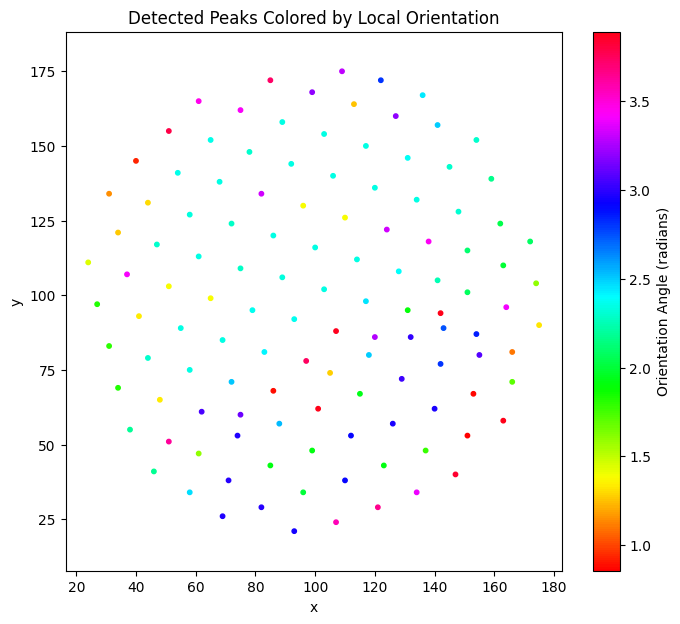

In [133]:
# Extract peaks
coords = extract_peak_coords_from_psi(psi, threshold=0.02, min_distance=2, mask=mask)

if len(coords) == 0:
    print("No peaks found with the current threshold and minimum distance.")
else:
    # Calculate orientations
    angs = local_orientation_angles(coords, k=6)

    # Convert integer coordinates to float for plotting
    pts = np.array([[float(i), float(j)] for i,j in coords])

    # Plot peaks colored by orientation
    plt.figure(figsize=(8, 7))
    scatter = plt.scatter(pts[:, 0], pts[:, 1], c=angs, cmap='hsv', s=10)
    plt.colorbar(scatter, label='Orientation Angle (radians)')
    plt.title('Detected Peaks Colored by Local Orientation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.show()

In [ ]:
def ch_step(c, psi, p, dt=5e-4, n_sub=10, mask=None, mobility=1.0): # Added mobility parameter
    c = c.astype(np.float64, copy=True)
    for _ in range(n_sub):
        mu = dgc_dc(c, p.RT, p.Om) - p.kappa * anisotropic_laplacian_c(
            c, c, p.alpha_fp, p.beta_fp, p.alpha_lfp, p.beta_lfp, p.dx, p.xi
        )
        # Include mobility in the update rule
        c += dt * mobility * laplacian(mu, p.dx)  # ∂c/∂τ = ∇² μ * M
        if mask is not None:
            c[~mask] = 1.0  # reservoir BC every substep
        np.clip(c, -1e-6, 1.0 + 1e-6, out=c)  # gentle clamp
        if not np.isfinite(c).all():
            raise FloatingPointError("CH step produced NaN/Inf — reduce dt or revise κ.")
    return c